In [ ]:
# Import dependencies
import numpy as np
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from rouge import Rouge
import networkx as nx
from nltk.tokenize import sent_tokenize
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

c:\Users\JG\github_repos\NLP_text_summarization\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import pickle

In [3]:
# Init
nlp = spacy.load("en_core_web_sm")

In [4]:
# Functions used in code

def build_sentence_matrix(preprocessed_sentences):
    vect = TfidfVectorizer()
    X = vect.fit_transform(preprocessed_sentences)
    return X.toarray()


def preprocess_text(text):
    # Usuwamy "(CNN)", "--", "''"
    text = text.replace("(CNN)", "").replace("--", "").replace("''", '"')
    # Dzielimy tekst na zdania
    sentences = sent_tokenize(text)

    preprocessed = []
    for sent in sentences:
        doc = nlp(sent.lower())
        cleaned_words = []
        for token in doc:
            if token.is_alpha and not token.is_stop and token.pos_ in {"NOUN", "VERB", "ADJ", "ADV"}:
                cleaned_words.append(token.lemma_)
        preprocessed.append(" ".join(cleaned_words))

    return preprocessed, sentences

def textrank_with_embedding(article_text , embedding_type: str = "tfidf", num_sentences=5,
                            damping_factor=0.85, similarity_threshold=0.1,
                            max_iter=100, tol=1e-6, max_input_sentences=None):
    # 1. Preprocess
    preprocessed, original_sentences = preprocess_text(article_text)

    # 2. Przycięcie
    if (max_input_sentences is not None) and max_input_sentences<=len(preprocessed):
        preprocessed = preprocessed[:max_input_sentences]
        original_sentences = original_sentences[:max_input_sentences]

    # 3. Budujemy macierz embeddingów / TF-IDF
    sentence_matrix = build_sentence_matrix(preprocessed)

    # 4. Kosinusowa macierz podobieństw
    

    sim_matrix = cosine_similarity(sentence_matrix, sentence_matrix)
    np.fill_diagonal(sim_matrix, 0.0)
    sim_matrix[sim_matrix < similarity_threshold] = 0.0

    # 6. Zbuduj graf i PageRank
    graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(graph, alpha=damping_factor, max_iter=max_iter, tol=tol)

    # 7. Sortowanie zdań po PageRank i wybór top num_sentences
    ranked = sorted(((score, idx) for idx, score in scores.items()), reverse=True)
    top_count = min(num_sentences, len(original_sentences))
    top_idxs = [idx for (_score, idx) in ranked[:top_count]]
    top_idxs.sort()

    # 8. Połącz oryginalne zdania i zwróć
    summary = " ".join([original_sentences[i] for i in top_idxs])
    return summary

def evaluate_embeddings(articles,highlights, num_sentences=5,
                        damping_factor=0.85, similarity_threshold=0.1,
                        max_iter=100, tol=1e-6):
    rouge = Rouge()
    results = []
    num_articles = len(articles)
    for i in range(num_articles):
        article = articles[i]
        highlight = highlights[i]

        summary = textrank_with_embedding(
            article, num_sentences=num_sentences,
            damping_factor=damping_factor, similarity_threshold=similarity_threshold,
            max_iter=max_iter, tol=tol, max_input_sentences=None
        )

        scores = rouge.get_scores(summary, highlight)[0]
        results.append({
            "rouge-1-f": scores["rouge-1"]["f"],
            "rouge-2-f": scores["rouge-2"]["f"],
            "rouge-l": scores["rouge-l"]["f"]
        })

        if (i + 1) % 10 == 0:
            print(f"  • {i+1}/{num_articles} artykułów przetworzono")
    return(results)

    Experiment
    # 2. For every hiperparameter
        # 1. Prepare Crossvalidation
        # 2. For every batch in crossvalidation
            # 1. Preprocessing 
            # 2. Shortening
            # 3. Embeddings
            # 4. Cosine Similarity
            # 5. Graph generation
            # 6. Page-Rank
            # 7. Sort
            # 8. Calculate matric
            # 8. Store txperiment results
    # 3. Process results
    # 4. Show results

## 1. Load dataset

In [5]:
dataset = load_dataset("cnn_dailymail", "3.0.0")

## 1.1 Prepare dataset for crossvalidation

In [6]:
articles = dataset['train']['article']
highlights = dataset['train']['highlights']

In [7]:
print("Article example: ",articles[0])
print("Highlight example: ",highlights[0])
print("Article example: ",articles[1])
print("Highlight example: ",highlights[1])
print("Ammount of examples:",len(highlights))

Article example:  LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office cha

In [8]:
len(sent_tokenize(highlights[0]))
sum = 0
for highlight in highlights[:1000]:
    sum = sum + len(sent_tokenize(highlight))
avg = sum/1000
print(avg)

3.525


In [89]:
optimisation_results = []
for damping_factor in np.arange(0.3,0.9,0.2):
    for max_iter in np.arange(100,1000,200):
        for tol in np.arange(0.1e-6,2.1e-6,0.5e-6):
            optimisation_results.append({
                'damping_factor': damping_factor,
                'max_iter': max_iter,
                'tol': tol,
                'results_array': evaluate_embeddings(articles = articles[:100],highlights=highlights[:100], num_sentences=4,damping_factor=damping_factor, similarity_threshold=0.1, max_iter=max_iter, tol=tol)
            })

  • 10/100 artykułów przetworzono
  • 20/100 artykułów przetworzono
  • 30/100 artykułów przetworzono
  • 40/100 artykułów przetworzono
  • 50/100 artykułów przetworzono
  • 60/100 artykułów przetworzono
  • 70/100 artykułów przetworzono
  • 80/100 artykułów przetworzono
  • 90/100 artykułów przetworzono
  • 100/100 artykułów przetworzono
  • 10/100 artykułów przetworzono
  • 20/100 artykułów przetworzono
  • 30/100 artykułów przetworzono
  • 40/100 artykułów przetworzono
  • 50/100 artykułów przetworzono
  • 60/100 artykułów przetworzono
  • 70/100 artykułów przetworzono
  • 80/100 artykułów przetworzono
  • 90/100 artykułów przetworzono
  • 100/100 artykułów przetworzono
  • 10/100 artykułów przetworzono
  • 20/100 artykułów przetworzono
  • 30/100 artykułów przetworzono
  • 40/100 artykułów przetworzono
  • 50/100 artykułów przetworzono
  • 60/100 artykułów przetworzono
  • 70/100 artykułów przetworzono
  • 80/100 artykułów przetworzono
  • 90/100 artykułów przetworzono
  • 100/100 

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

In [83]:
df = pd.DataFrame(optimisation_results)
with open("optimisation_results_df.pkl", "wb") as f:
    pickle.dump(df, f)

In [87]:
df

,damping_factor,max_iter,tol,results_array
0,0.40,100,1.000000e-07,0.239372
1,0.40,100,6.000000e-07,0.239372
2,0.40,100,1.100000e-06,0.239372
3,0.40,100,1.600000e-06,0.239372
4,0.40,550,1.000000e-07,0.239372
5,0.40,550,6.000000e-07,0.239372
6,0.40,550,1.100000e-06,0.239372
7,0.40,550,1.600000e-06,0.239372
8,0.65,100,1.000000e-07,0.244754
9,0.65,100,6.000000e-07,0.244754


In [85]:
# Step 1: Extract relevant info


def mean_rouge1(results_array):
    sum = 0
    ammount = len(results_array)
    for i in range(ammount):
        sum = sum + results_array[i]["rouge-1-f"]
    return(sum/ammount)

# Apply to each row
df['results_array'] = df['results_array'].apply(mean_rouge1)

In [86]:

[df['results_array'][i][0]['rouge-1-f'] for i in range(150)]

IndexError: invalid index to scalar variable.

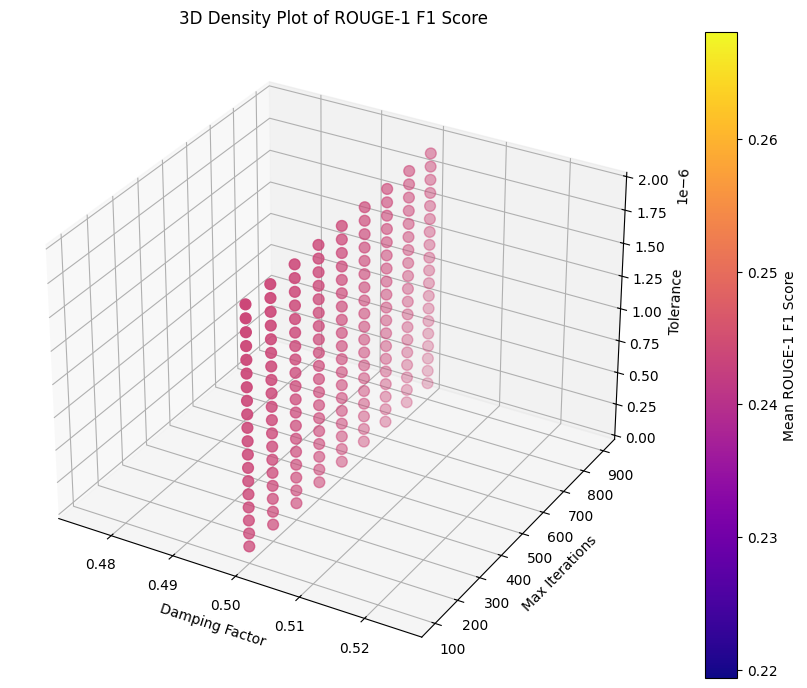

In [74]:

# Step 3: Plot 3D scatter with color density
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    df['damping_factor'],
    df['max_iter'],
    df['tol'],
    c=df['results_array'],
    cmap='plasma',
    s=60
)

ax.set_xlabel('Damping Factor')
ax.set_ylabel('Max Iterations')
ax.set_zlabel('Tolerance')
plt.title('3D Density Plot of ROUGE-1 F1 Score')

# Add color bar
cbar = plt.colorbar(sc)
cbar.set_label('Mean ROUGE-1 F1 Score')

plt.tight_layout()
plt.show()

In [ ]:
pd.DataFrame(optimisation_results)['results_df']

NameError: name 'pd' is not defined